In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import ar_model
#from statsmodels.tsa import arima_model     # depricated
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from pandas.plotting import autocorrelation_plot

# mauna loa volcano co2
### read data and use `pandas` date functionality
### resample data
### investigate autocorrelation with `pandas` and `statsmodels`
### de-trend
### seasonal decomposition with `statsmodels`
### auto regressive model with `statsmodels`
### ARIMA with `statsmodels`
### 1d `sklearn` for trend
### quadratic model `sklearn` for trend
### detrend then model residuals

# read data

### just read columns

In [3]:
url = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt"
names = ['year', 'month', 'day', 'year_decimal', 'co2', 'days', '1 yr ago', 
         '10 yr ago', 'since 1880']

maunaloa = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                       names=names, na_values=[-999.99])

In [4]:
maunaloa.head()

,year,month,day,year_decimal,co2,days,1 yr ago,10 yr ago,since 1880
0,1974,5,19,1974.3795,333.34,6,NaN,NaN,50.36
1,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06
2,1974,6,2,1974.4178,332.32,5,NaN,NaN,49.57
3,1974,6,9,1974.4370,332.18,7,NaN,NaN,49.63
4,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.07


### use pandas date functionality when read file

In [7]:
maunaloa_2 = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                         names=names, parse_dates=[[0,1,2]],
                         na_values=[-999.99])
maunaloa_2.head()

,year_month_day,year_decimal,co2,days,1 yr ago,10 yr ago,since 1880
0,1974-05-19,1974.3795,333.34,6,NaN,NaN,50.36
1,1974-05-26,1974.3986,332.95,6,NaN,NaN,50.06
2,1974-06-02,1974.4178,332.32,5,NaN,NaN,49.57
3,1974-06-09,1974.4370,332.18,7,NaN,NaN,49.63
4,1974-06-16,1974.4562,332.37,7,NaN,NaN,50.07


In [10]:
maunaloa_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427 entries, 0 to 2426
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year_month_day  2427 non-null   datetime64[ns]
 1   year_decimal    2427 non-null   float64       
 2   co2             2407 non-null   float64       
 3   days            2427 non-null   int64         
 4   1 yr ago        2358 non-null   float64       
 5   10 yr ago       1885 non-null   float64       
 6   since 1880      2407 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 132.9 KB


### use pandas date functionality and time series index when read file

In [8]:
maunaloa_3 = pd.read_csv(url, skiprows=49, header=None, delim_whitespace=True,
                         names=names, parse_dates=[[0,1,2]],
                         na_values=[-999.99], index_col='year_month_day')
maunaloa_3.head()

,year_decimal,co2,days,1 yr ago,10 yr ago,since 1880
year_month_day,,,,,,
1974-05-19,1974.3795,333.34,6,NaN,NaN,50.36
1974-05-26,1974.3986,332.95,6,NaN,NaN,50.06
1974-06-02,1974.4178,332.32,5,NaN,NaN,49.57
1974-06-09,1974.4370,332.18,7,NaN,NaN,49.63
1974-06-16,1974.4562,332.37,7,NaN,NaN,50.07


In [9]:
maunaloa_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2427 entries, 1974-05-19 to 2020-11-15
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year_decimal  2427 non-null   float64
 1   co2           2407 non-null   float64
 2   days          2427 non-null   int64  
 3   1 yr ago      2358 non-null   float64
 4   10 yr ago     1885 non-null   float64
 5   since 1880    2407 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 132.7 KB


<AxesSubplot:xlabel='year_month_day'>

Text(0, 0.5, 'CO2 ppm')

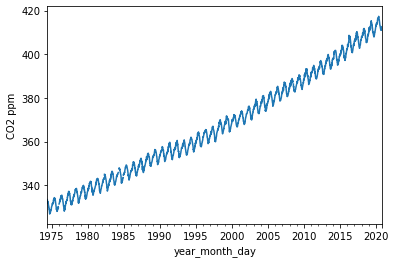

In [14]:
maunaloa_3['co2'].plot()
plt.ylabel('CO2 ppm')

### handle missing values via foward fill

In [15]:
maunaloa_3['co2'].isnull().sum()

20

In [16]:
maunaloa_3.fillna(method='ffill', inplace=True)
maunaloa_3['co2'].isnull().sum()

0

# resampling
- original data is weekly   
   
### `DataFrame.resample`
`MS` is `month start` frequency   
`resample` is lazy (like `groupby`), must request an output   
   
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html   
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.resample.html#pandas.Series.resample   
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In [17]:
resampled_co2 = maunaloa_3['co2'].resample('MS')
resampled_co2

In [19]:
resampled_co2.mean().head()

year_month_day
1974-05-01    333.1450
1974-06-01    332.0280
1974-07-01    330.7125
1974-08-01    329.0725
1974-09-01    327.3240
Freq: MS, Name: co2, dtype: float64

### plot resampling

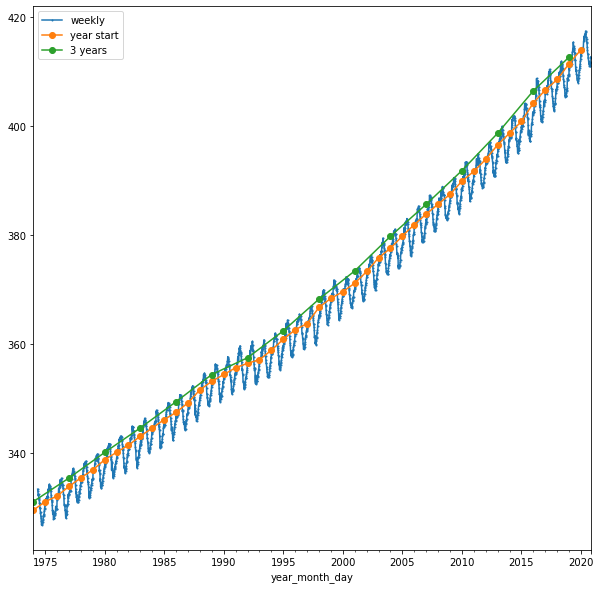

In [25]:
_ = plt.figure(figsize=(10,10))
_ = maunaloa_3['co2'].resample('W').mean().plot(marker='o', markersize=1, label='weekly')
_ = maunaloa_3['co2'].resample('AS').mean().plot(marker='o', label='year start')
_ = maunaloa_3['co2'].resample('3AS').mean().plot(marker='o', label='3 years')
_ = plt.legend()

# autocorrelation
- recall that data is weekly  
   
### `DataFrame.autocorr`
- default `lag=1`

In [26]:
maunaloa_3['co2'].autocorr()

0.9997336892558758

In [28]:
maunaloa_3['co2'].autocorr(lag=26)

0.984247192583535

In [29]:
maunaloa_3['co2'].autocorr(lag=52)

0.9994900207352759

### autocorrelation plot with `statsmodels`

In [152]:
autocorrelation = acf(maunaloa_3['co2'], nlags=100, fft=False)

In [153]:
type(autocorrelation)
autocorrelation.shape

numpy.ndarray

(101,)

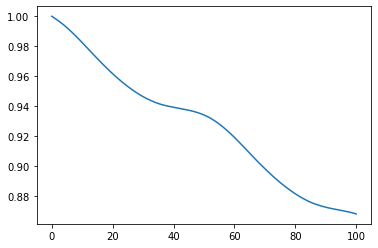

In [154]:
_ = plt.plot(autocorrelation)

### autocorrelation plot with `pandas`

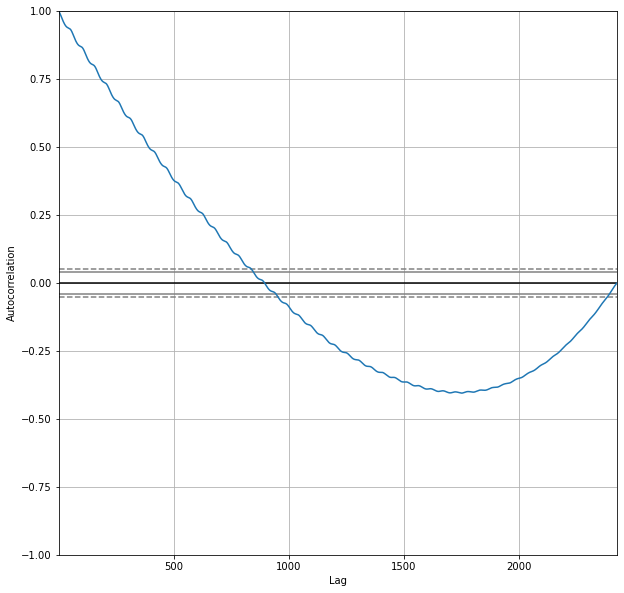

In [155]:
_ = plt.figure(figsize=(10,10))
_ = autocorrelation_plot(maunaloa_3['co2'])

# de-trend (remove mean)
### `DataFrame.diff`
- default `periods=1`

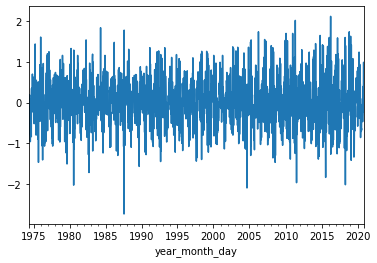

In [50]:
_ = maunaloa_3['co2'].diff().plot()

### auto correlation of differenced data
use to determine if periodic pattern

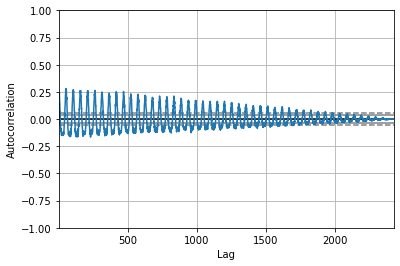

In [51]:
_ = autocorrelation_plot(maunaloa_3['co2'].diff()[1:])

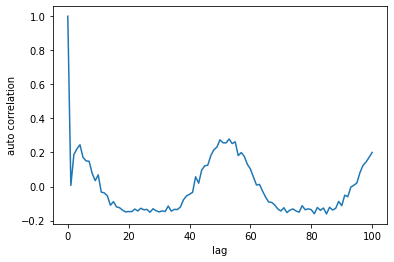

In [59]:
_ = plt.plot(acf(maunaloa_3['co2'].diff()[1:], nlags=100, fft=False))
_ = plt.xlabel('lag')
_ = plt.ylabel('auto correlation')

# seasonal decomposition with `statsmodels`

In [61]:
decomposition = seasonal_decompose(maunaloa_3['co2'], model='additive')

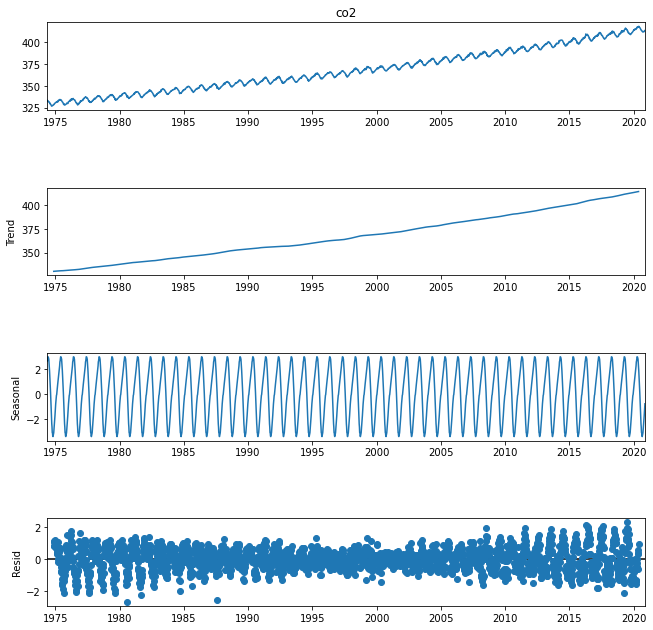

In [67]:
fig = decomposition.plot()
_ = fig.set_figheight(10)
_ = fig.set_figwidth(10)

# auto regressive (linear) model
video
- speaker said his example was monthly data so use `maxlag=12`   
- his data had 709 values but here monthly resample has only 559

### resample monthly

In [94]:
maunaloa_3['co2'].shape

(2427,)

In [95]:
resample = maunaloa_3['co2'].resample('MS')
ppm_monthly = resample.mean()

In [96]:
ppm_monthly.shape
ppm_monthly.head()

(559,)

year_month_day
1974-05-01    333.1450
1974-06-01    332.0280
1974-07-01    330.7125
1974-08-01    329.0725
1974-09-01    327.3240
Freq: MS, Name: co2, dtype: float64

In [103]:
# this usage is deprecated
#ar = ar_model.AR(ppm_monthly[:300])
#res = ar.fit(maxlag=12)

C:\Users\LoriN\anaconda3\envs\python3_7\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, Fut

### `statsmodels` auto reg

In [110]:
ar = ar_model.AutoReg(ppm_monthly[:300], lags=12)
res = ar.fit()

C:\Users\LoriN\anaconda3\envs\python3_7\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [111]:
res.params

intercept   -1.093623
co2.L1       0.910682
co2.L2      -0.206463
co2.L3      -0.172539
co2.L4      -0.016841
co2.L5       0.183085
co2.L6      -0.075296
co2.L7       0.033071
co2.L8      -0.139883
co2.L9       0.081861
co2.L10      0.037159
co2.L11      0.330380
co2.L12      0.039665
dtype: float64

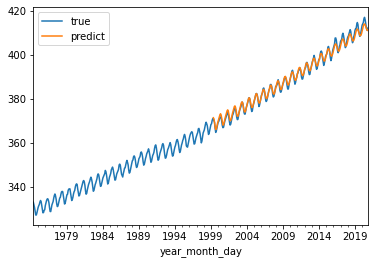

In [112]:
_ = ppm_monthly.plot(label='true')
_ = res.predict(ppm_monthly.index[300], ppm_monthly.index[-1]).plot(label='predict')

_ = plt.legend()

### auto regressive (linear) model--impact of order 

C:\Users\LoriN\anaconda3\envs\python3_7\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


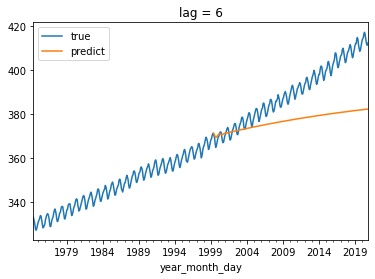

In [113]:
ar6 = ar_model.AutoReg(ppm_monthly[:300], lags=6)
res6 = ar6.fit()

_ = ppm_monthly.plot(label='true')
_ = res6.predict(ppm_monthly.index[300], ppm_monthly.index[-1]).plot(label='predict')
_ = plt.legend()
_ = plt.title('lag = 6')

C:\Users\LoriN\anaconda3\envs\python3_7\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


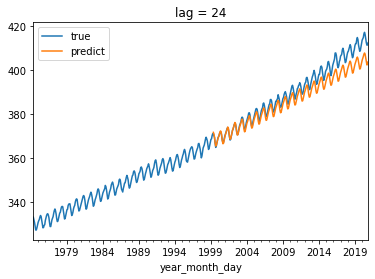

In [116]:
ar24 = ar_model.AutoReg(ppm_monthly[:300], lags=24)
res24 = ar24.fit()

_ = ppm_monthly.plot(label='true')
_ = res24.predict(ppm_monthly.index[300], ppm_monthly.index[-1]).plot(label='predict')
_ = plt.legend()
_ = plt.title('lag = 24')

# ARIMA (auto regressive integrated moving average)
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html   
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/   

C:\Users\LoriN\anaconda3\envs\python3_7\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LoriN\anaconda3\envs\python3_7\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\LoriN\anaconda3\envs\python3_7\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


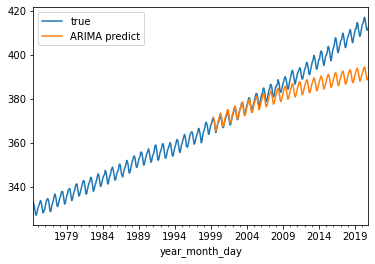

In [215]:
#the_model = arima_model.ARIMA(ppm_monthly[:300], order=(12,1,0))
#the_model = ARIMA(ppm_monthly[:300], order=(12,1,12), trend='ct')
the_model = ARIMA(ppm_monthly[:300], order=(12,1,12))
ar_res = the_model.fit()

_ = ppm_monthly.plot(label='true')
_ = ar_res.predict(ppm_monthly.index[300], ppm_monthly.index[-1]).plot(label='ARIMA predict')
_ = plt.legend()

In [216]:
print(ar_res.summary())

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                  300
Model:               ARIMA(12, 1, 12)   Log Likelihood                -108.717
Date:                Sat, 28 Nov 2020   AIC                            267.434
Time:                        17:09:57   BIC                            359.945
Sample:                    05-01-1974   HQIC                           304.461
                         - 04-01-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2879      0.181     -1.591      0.112      -0.643       0.067
ar.L2          0.0532      0.142      0.374      0.708      -0.226       0.332
ar.L3          0.3065      0.133      2.298      0.0

# 1d `sklearn` for trend
examples in video had 709 values; fit with 500

In [119]:
ppm_monthly.shape

(559,)

In [156]:
train = ppm_monthly[:400]
test  = ppm_monthly[400:]
X = ppm_monthly.index.to_series().apply(lambda x: x.toordinal())
X = pd.DataFrame(X)
X_train, X_test = X.iloc[:400, :], X.iloc[400:, :]
X_train.shape

(400, 1)

In [157]:
lr = LinearRegression().fit(X_train, train)
#lr_pred = lr.predict(X_test)

In [158]:
pred_lr = lr.predict(X)
pred_lr.shape

df_pred_lr = pd.DataFrame(pred_lr, index=ppm_monthly.index, columns=['predict'])
df_pred_lr.head()

(559,)

,predict
year_month_day,
1974-05-01,328.432094
1974-06-01,328.567929
1974-07-01,328.699382
1974-08-01,328.835218
1974-09-01,328.971053


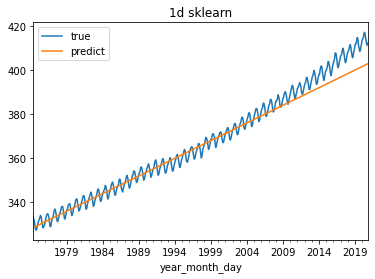

In [159]:
fig, ax = plt.subplots(1,1)
_ = ppm_monthly.plot(label='true', ax=ax)
_ = df_pred_lr.plot(label='predict', ax=ax)
_ = plt.legend()
_ = plt.title('1d sklearn')

# quadratic model `sklearn` for trend

In [160]:
lr_poly = make_pipeline(PolynomialFeatures(include_bias=False), LinearRegression())
lr_poly.fit(X_train, train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

In [161]:
pred_lr_poly = lr_poly.predict(X)
df_pred_lr_poly = pd.DataFrame(pred_lr_poly, index=ppm_monthly.index, columns=['predict'])
df_pred_lr_poly.head()

,predict
year_month_day,
1974-05-01,330.033366
1974-06-01,330.144685
1974-07-01,330.252532
1974-08-01,330.364098
1974-09-01,330.475790


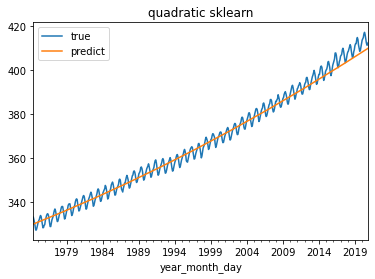

In [162]:
fig, ax = plt.subplots(1,1)
_ = ppm_monthly.plot(label='true', ax=ax)
_ = df_pred_lr_poly.plot(label='predict', ax=ax)
_ = plt.legend()
_ = plt.title('quadratic sklearn')

# detrend then model residuals
### use quadratic fit for trend
video 54:16

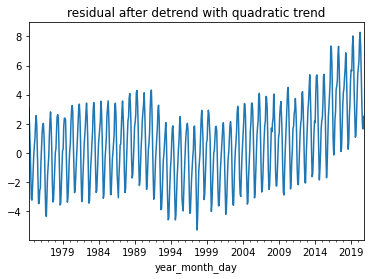

In [164]:
y_res = ppm_monthly - pred_lr_poly
_ = y_res.plot()
_ = plt.title('residual after detrend with quadratic trend')

### AR model for residual

In [169]:
ar_residual = ar_model.AutoReg(y_res[:300], lags=12)
res_residual = ar_residual.fit()

C:\Users\LoriN\anaconda3\envs\python3_7\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [171]:
pred_res_residual = res_residual.predict(y_res.index[300], y_res.index[-1]) 

In [181]:
temp = df_pred_lr_poly[300:]
temp.head()

,predict
year_month_day,
1999-05-01,368.246158
1999-06-01,368.394432
1999-07-01,368.538041
1999-08-01,368.686562
1999-09-01,368.835207


In [184]:
temp2 = pd.DataFrame(pred_res_residual)
temp2.head()

,0
1999-05-01,3.201968
1999-06-01,2.512047
1999-07-01,0.700857
1999-08-01,-1.426479
1999-09-01,-2.779801


In [185]:
(temp['predict'] + temp2[0]).head()

year_month_day
1999-05-01    371.448127
1999-06-01    370.906478
1999-07-01    369.238898
1999-08-01    367.260083
1999-09-01    366.055407
Freq: MS, dtype: float64

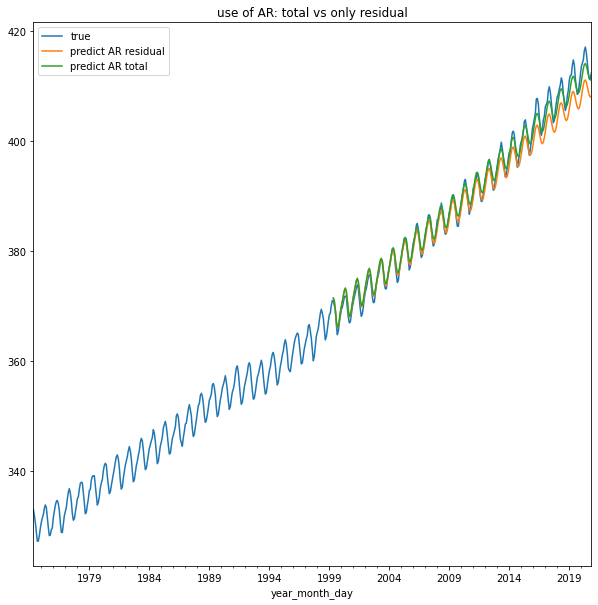

In [190]:
_ = plt.figure(figsize=(10,10))

_ = ppm_monthly.plot(label='true')
_ = ((temp['predict'] + temp2[0])).plot(label='predict AR residual')
_ = res.predict(ppm_monthly.index[300], ppm_monthly.index[-1]).plot(label='predict AR total')

_ = plt.legend()
_ = plt.title('use of AR: total vs only residual')